In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import rasterio
import matplotlib.ticker as ticker

# READ-ME


In [ ]:
'''
DEPENDENCIES: pands, numpy, tqdm, matplotlib, rasterio

INPUT DATA: 
- CSV FILES FOR EACH THRESHOLD (Threshold_150.csv, etc.) ---> THESE WERE CREATED IN THE 'SUBMISSION_Getting_passable_days.ipynb' NOTEBOOK
- FUTURE ICE MAPS ---> THESE WERE CREATED IN 'SUBMISSION_Forcasting_Ice.ipynb' NOTEBOOK

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

WHAT THIS NOTEBOOK DOES:
- FINDS THE NAVIGABLE DAYS PER ROUTE OVER TIME (DATA FROM THE CSV FILES)
- FINDS THE NEWLY NAVIGABLE AREA AT 'ELBOW' TO FIND HOLD-UP REGION (A LOT OF MANUALLY CHECKING AND INVESTIGATION WAS DONE HERE SO OUTPUT IS NOT AUTOMATED)
- FINDS HOW RISK TOLERANCE AFFECTS ROUTE LENGTH 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

FOR QUESTION OR ISSUES CONTACT: 
- Ioannis Thomopoulos       -->  ioannis.thomopoulos@studbocconi.it
- Jacopo D'Angelo           -->  jacopo.dangelo@studbocconi.it
- Max Rienth                -->  maximilian.rienth@studbocconi.it
- Luca Milani               -->  luca.milani2@studbocconi.it

'''

''

# NAVIGABLE DAYS PER ROUTE OVER TIME


Computing annual counts: 100%|██████████| 5/5 [00:00<00:00, 826.43it/s]


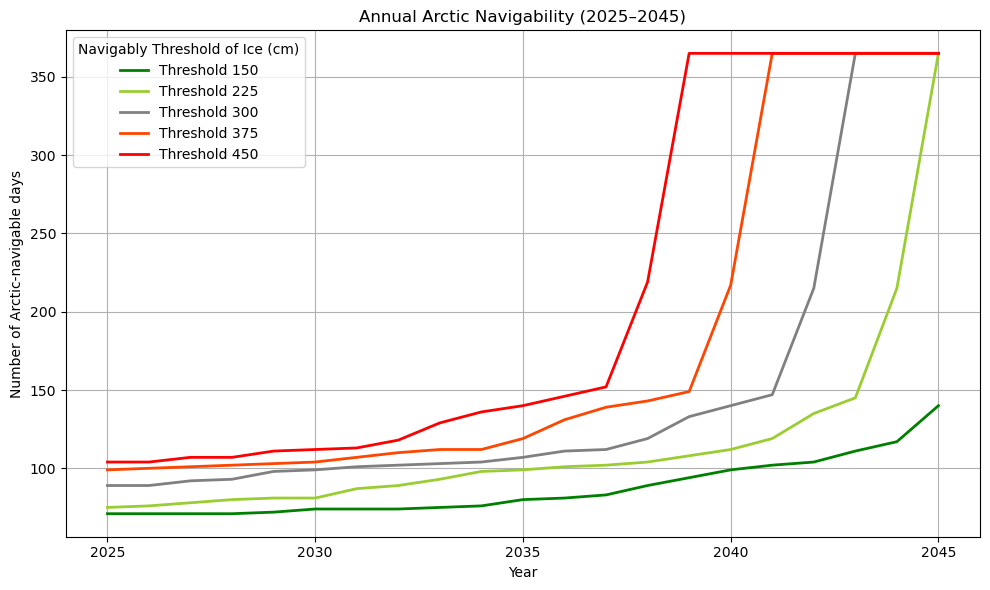

In [14]:
# Constants for route distance-thresholds
ROUTE_THRESHOLDS = {
    'Shanghai to New York': 800,
    'Shanghai to Rotterdam': 750,
    'Singapore to New York': 900,
    'Singapore to Rotterdam': 750,
}

# Ice thresholds and corresponding filenames
ICE_THRESHOLDS = [150, 225, 300, 375, 450]
FILENAMES = {th: f'created_data/Threshold_{th}.csv' for th in ICE_THRESHOLDS}

# Create full date range from 2025-01-01 to 2045-12-31 (omit Feb 29)
all_dates = pd.date_range(start='2025-01-01', end='2045-12-31', freq='D')
all_dates = all_dates[~((all_dates.month == 2) & (all_dates.day == 29))]
template_df = pd.DataFrame({'Date': all_dates})

# Task 1: build filtered DataFrames for each ice threshold
for th in tqdm(ICE_THRESHOLDS, desc='Building filtered dataframes'):
    df = pd.read_csv(FILENAMES[th], dtype={'date': str})
    df['Date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df = df[['Date'] + list(ROUTE_THRESHOLDS.keys())]
    merged = template_df.merge(df, on='Date', how='left')
    for route, dist_thresh in ROUTE_THRESHOLDS.items():
        merged[route] = (merged[route] < dist_thresh).astype(int)
    globals()[f'data_{th}_filtered'] = merged

# Task 2: compute annual navigable-day counts and plot
thresholds = ICE_THRESHOLDS
colors = {
    150: 'green',
    225: 'yellowgreen',
    300: 'grey',
    375: 'orangered',
    450: 'red'
}
route_cols = list(ROUTE_THRESHOLDS.keys())

annual_counts = {}
for th in tqdm(thresholds, desc='Computing annual counts'):
    df = globals()[f'data_{th}_filtered']
    df['Year'] = df['Date'].dt.year
    df['navigable'] = df[route_cols].any(axis=1).astype(int)
    annual_counts[th] = df.groupby('Year')['navigable'].sum()

annual_df = pd.DataFrame(annual_counts)
annual_df = annual_df.reindex(range(2025, 2046), fill_value=0)

plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(
        annual_df.index,
        annual_df[th],
        label=f'Threshold {th}',
        color=colors[th],
        linewidth=2
    )

plt.xlabel('Year')
plt.ylabel('Number of Arctic-navigable days')
plt.title('Annual Arctic Navigability (2025–2045)')
plt.xticks(range(2025, 2046, 5))
plt.legend(title='Navigably Threshold of Ice (cm)', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# NEWLEY NAVIAGABLE AREA (CHECKING FOR HOLD-UP LOCATION)


Total newly navigable pixels from 20350710 to 20350713: 595


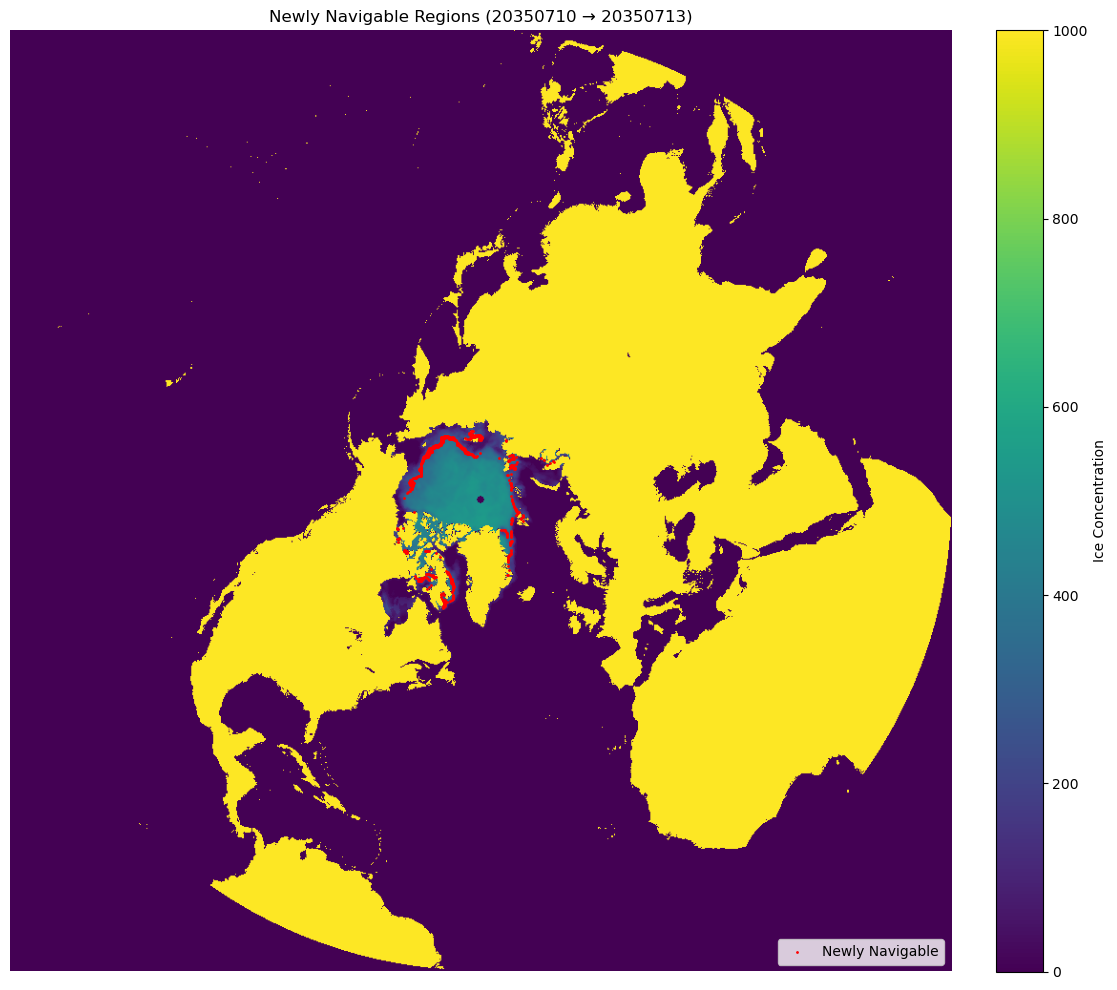

In [12]:
# Parameters
INPUT_FOLDER = 'created_data/future_ice_maps'
LAND_VAL = 3000
ICE_THRESHOLD = 300

def load_ice_data(filename):
    with rasterio.open(filename) as src:
        ice_data = src.read(1)
    return ice_data

def load_navigable_mask(filename, ice_threshold=ICE_THRESHOLD, land_val=LAND_VAL):
    with rasterio.open(filename) as src:
        grid = src.read(1)
    navigable = (grid <= ice_threshold) & (grid != land_val)
    return navigable

def overlay_new_navigable_on_ice(date_start, date_end, label):
    # Load ice data for the 'end' date (where new navigability might appear)
    ice_file = f"{INPUT_FOLDER}/ice_{date_end}.tif"
    ice_data = load_ice_data(ice_file)

    # Load navigable masks
    mask_end   = load_navigable_mask(ice_file)
    mask_start = load_navigable_mask(f"{INPUT_FOLDER}/ice_{date_start}.tif")

    # Identify newly navigable pixels
    newly_navigable_mask = mask_end & (~mask_start)

    # Count
    total_new_pixels = np.count_nonzero(newly_navigable_mask)
    print(f"Total newly navigable pixels from {date_start} to {date_end}: {total_new_pixels}")

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    img = ax.imshow(ice_data, cmap='viridis', vmin=0, vmax=1000)
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label="Ice Concentration")

    # Overlay newly navigable pixels in red
    newly_navigable = np.where(newly_navigable_mask)
    ax.scatter(newly_navigable[1], newly_navigable[0], color='red', s=1, label='Newly Navigable')

    ax.set_title(f"Newly Navigable Regions ({label})")
    ax.axis('off')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# EXAMPLE USAGE
DATE_START = '20350710'
DATE_END   = '20350713'
overlay_new_navigable_on_ice(date_start=DATE_START, date_end=DATE_END, label=f"{DATE_START} → {DATE_END}")

# ROUTE LENGTH VS RISK TOLERANCE


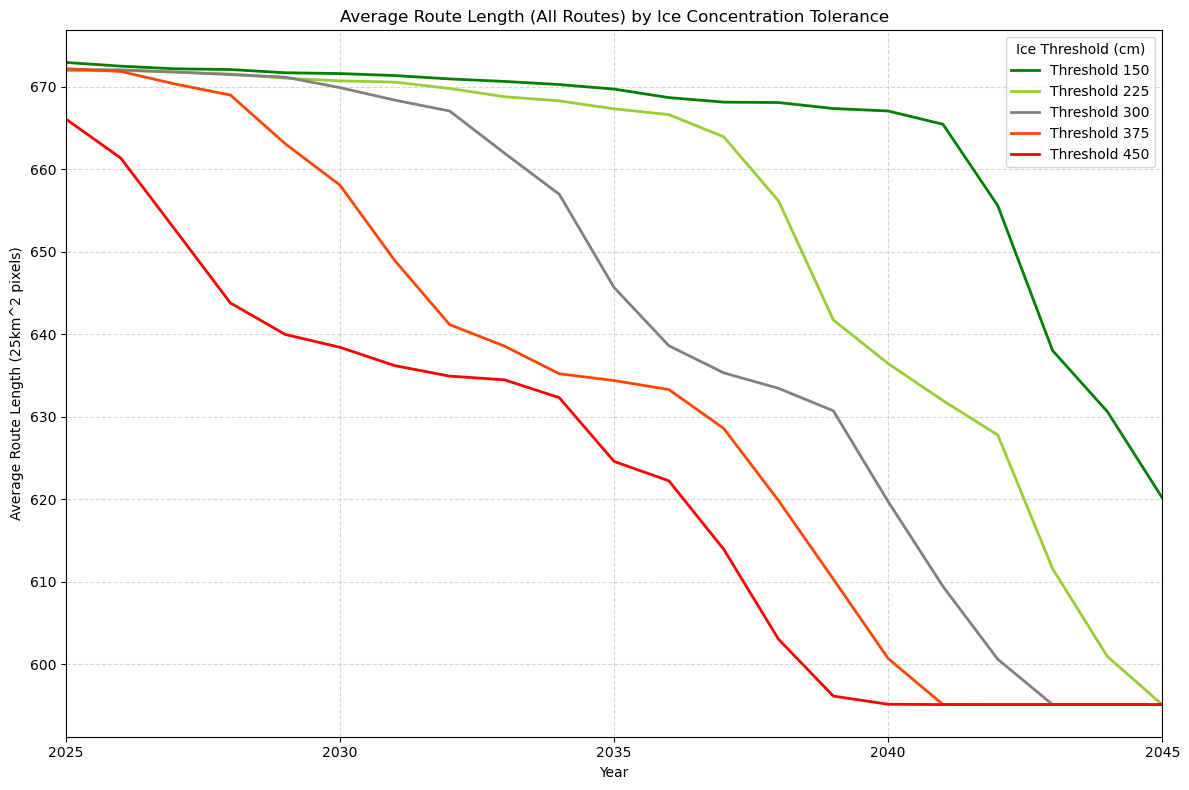

In [9]:
# Constants
ICE_THRESHOLDS = [150, 225, 300, 375, 450]
ROUTE_THRESHOLDS = {
    'Shanghai to New York': 800,
    'Shanghai to Rotterdam': 750,
    'Singapore to New York': 900,
    'Singapore to Rotterdam': 750,
}
FILENAMES = {th: f'created_data/Threshold_{th}.csv' for th in ICE_THRESHOLDS}
years = pd.Index(range(2025, 2046))

# Use your custom color scheme
colors = {
    150: 'green',
    225: 'yellowgreen',
    300: 'grey',
    375: 'orangered',
    450: 'red'
}

# Dictionary to store average route lengths per threshold
overall_avg_lengths = {}

for th in ICE_THRESHOLDS:
    df = pd.read_csv(FILENAMES[th])

    # Improved date handling
    if 'date' not in df.columns:
        raise ValueError(f"Missing 'date' column in {FILENAMES[th]}!")
    # Convert to numeric, coerce bad entries
    df['date'] = pd.to_numeric(df['date'], errors='coerce')
    # Drop rows where date is NaN
    df = df.dropna(subset=['date'])
    # Convert date to int then string
    df['date'] = df['date'].astype(int).astype(str)
    # Extract Year
    df['Year'] = df['date'].str[:4].astype(int)

    # Filter valid rows
    valid_mask = pd.Series(True, index=df.index)
    for route, limit in ROUTE_THRESHOLDS.items():
        valid_mask &= (df[route] < limit)

    # Compute average across routes, for valid rows
    if valid_mask.any():
        valid_rows = df.loc[valid_mask, ROUTE_THRESHOLDS.keys()]
        avg_route_length = valid_rows.mean(axis=1)
        avg_by_year = avg_route_length.groupby(df.loc[valid_mask, 'Year']).mean()
    else:
        avg_by_year = pd.Series(dtype=float)

    # Reindex to cover all years
    avg_by_year = avg_by_year.reindex(years, fill_value=None)
    overall_avg_lengths[th] = avg_by_year

# Plotting: Single graph for all thresholds
plt.figure(figsize=(12, 8))

for th, avg_series in overall_avg_lengths.items():
    plt.plot(
        avg_series.index,
        avg_series.values,
        label=f'Threshold {th}',
        color=colors[th],
        linewidth=2
    )

plt.xlabel('Year')
plt.ylabel('Average Route Length (25km^2 pixels)')
plt.title('Average Route Length (All Routes) by Ice Concentration Tolerance')
plt.xlim(2025, 2045)
plt.xticks(range(2025, 2046, 5))  # Set x-ticks to every 5 years
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.legend(title='Ice Threshold (cm)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()